## Test Case components prototyping

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Tuple
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense


In [2]:
# no scientific notation prnting
np.set_printoptions(suppress=True)
def set_plt_font(size: int):
  plt.rc('xtick', labelsize=size) 
  plt.rc('ytick', labelsize=size) 
  plt.rc('legend', fontsize=size) 

set_plt_font(40)

### Function definition port to module

In [108]:
def showme(x,samples:Union[None, int, tuple], w:int=100, h:int=10, y_axis_lim: Union[None,Tuple]=None):
  if samples is None:
    n_samples = 0, len(x)
  else:
    if isinstance(samples,int):
      n_samples = 0, samples
    else:
      n_samples = samples

  plt.figure(figsize=(w,h))
  if y_axis_lim is not None:
    plt.ylim(*y_axis_lim)
  plt.plot(x[n_samples[0]:n_samples[1]])
  plt.show()
  print(f'Showing: from {n_samples[0]} to {n_samples[1]} - Shape of data: {x.shape}')

def to_radian(degrees):
  return degrees * (np.pi / 180)

def signal_f(x: Union[int, float], epsilon: float=0.000000001) -> Union[int, float]:
  return x * (1+ 1/(x+epsilon)) 

def rolling_window(x, window):
    shape = (x.size - window + 1, window)
    strides = (x.itemsize, x.itemsize)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

def moving_average(x, steps):
  return np.convolve(x, np.ones(steps), 'valid') / steps

In [4]:
show_samples = 5000

In [5]:
def generate_raw_signal(max_degrees: int, steps_ratio: Union[int, float]) -> Tuple:

  steps = int(max_degrees/steps_ratio) 
  print(f'max_degrees: {max_degrees} steps: {steps}')
  degrees = np.linspace(0, max_degrees,steps, endpoint=False).astype(int)
  reversed_degrees = np.linspace(max_degrees, 0, steps, endpoint=False).astype(int)  

  return degrees, reversed_degrees

In [20]:
def stack_data(degree_data: Union[np.array, Tuple], n_iters: int, to_radians: bool = False) -> np.array:

  
  if isinstance(degree_data, np.ndarray):
    data = degree_data
    for i in range(n_iters):
      data = np.concatenate((data, degree_data))

  else: 
    data = degree_data[0]
    for i in range(n_iters):
      if i % 2 == 0:
        data = np.concatenate((data, degree_data[1]))
      else:
        data = np.concatenate((data, degree_data[0]))

  if to_radians:
    data = to_radian(data)

  print(f'Shape of data: {data.shape}')
  return data

In [7]:
def skewed_noise(n_samples: int, params: tuple=(1,1), dist_type='gamma', random_state=43):
    
  np.random.seed(random_state)

  if dist_type == "normal":
    mu, sigma = params
    random_signal = np.random.normal(mu, sigma, n_samples)    

  elif dist_type == "gamma":
    shape, scale = params #  .7, .3  # mean=4, std=2*sqrt(2)
    random_signal = np.random.gamma(shape, scale, n_samples)

  return random_signal

In [88]:
def signal_fusion(cyclic_signal: np.array, 
                  random_signal: np.array, 
                  size_coef: float = 1, 
                  starting_point: Union[float, None] = None, 
                  cumulative: bool = True) -> np.array:

  s_mixed = cyclic_signal * random_signal * size_coef
  
  if starting_point is not None:
    first_point = s_mixed[0]
    s_mixed[0] = starting_point
    print(f'{first_point} - {starting_point} - {s_mixed[0]}')

  if cumulative:
    s_mixed = np.cumsum(s_mixed)
    print(s_mixed[:10])
  
  return s_mixed

In [9]:
def seq2inputs(sequence: np.array, time_step_to_predict: int = 1) -> Tuple:
  X = sequence[:-1,:]
  y = sequence[:,time_step_to_predict][1:]
  print(f'Shape of feature: {X.shape} - Shape of target: {y.shape}')
  return X, y

In [10]:
def split_dataset(X: np.array, y: np.array, split_size: float =0.8) -> Tuple:
  n_train_total = int(len(X) * split_size)
  n_train = int(n_train_total * split_size)
  print(f'n_train: {n_train} - n_train_pre: {n_train_total}')

  X_train = X[:n_train]
  X_val = X[n_train:n_train_total]
  X_test = X[n_train_total: ]
  y_train = y[:n_train]
  y_val = y[n_train:n_train_total]
  y_test = y[n_train_total: ]
  return X_train, X_val, X_test, y_train, y_val, y_test


### Signal Generation

In [11]:
# samples to plot
show_samples = 0, 500

max_degrees: 360 steps: 9000


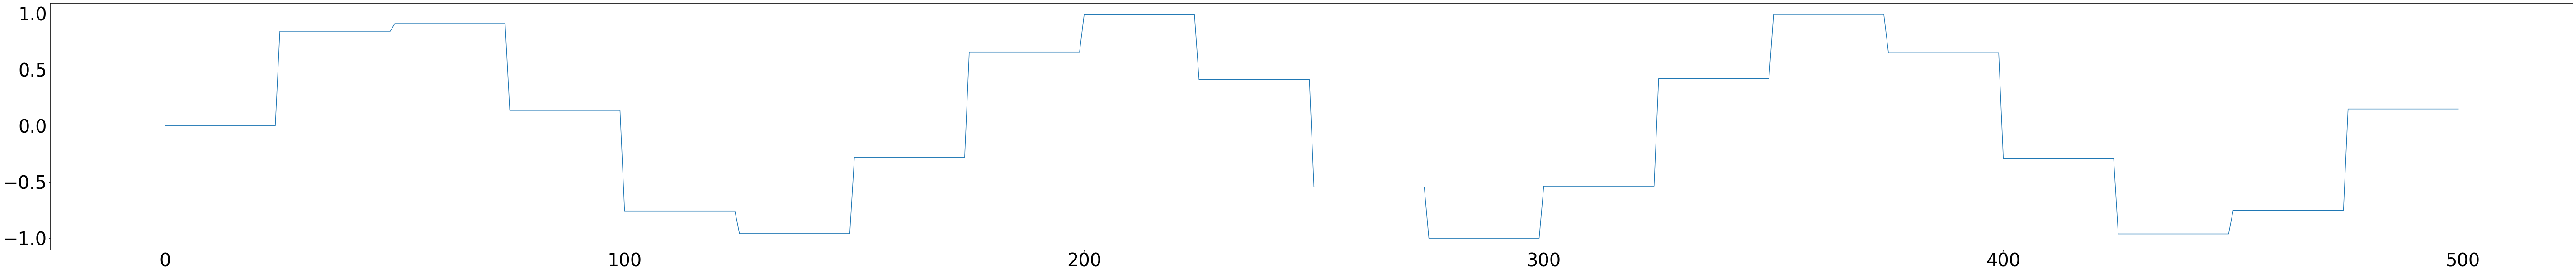

Showing: from 0 to 500 - Shape of data: (18000,)


In [21]:
raw_1 = generate_raw_signal(max_degrees=360, steps_ratio=0.04)
r = np.hstack(raw_1)
s = np.sin(r)
showme(s, 500)

max_degrees: 360 steps: 9000
Shape of data: (99000,)
total timesteps: 99000


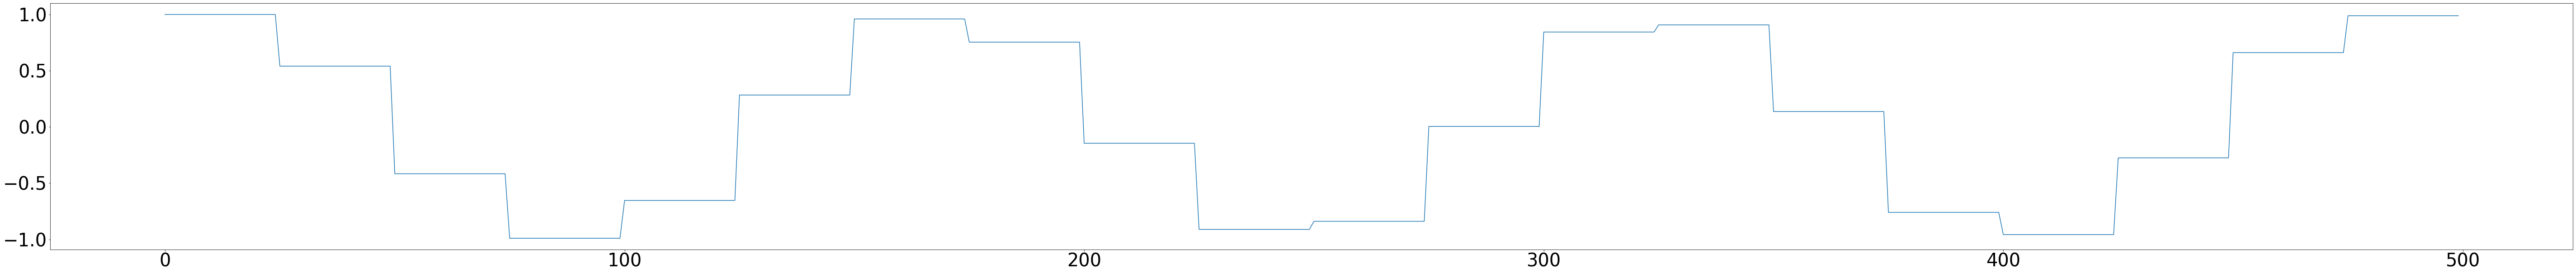

Showing: from 0 to 500 - Shape of data: (99000,)


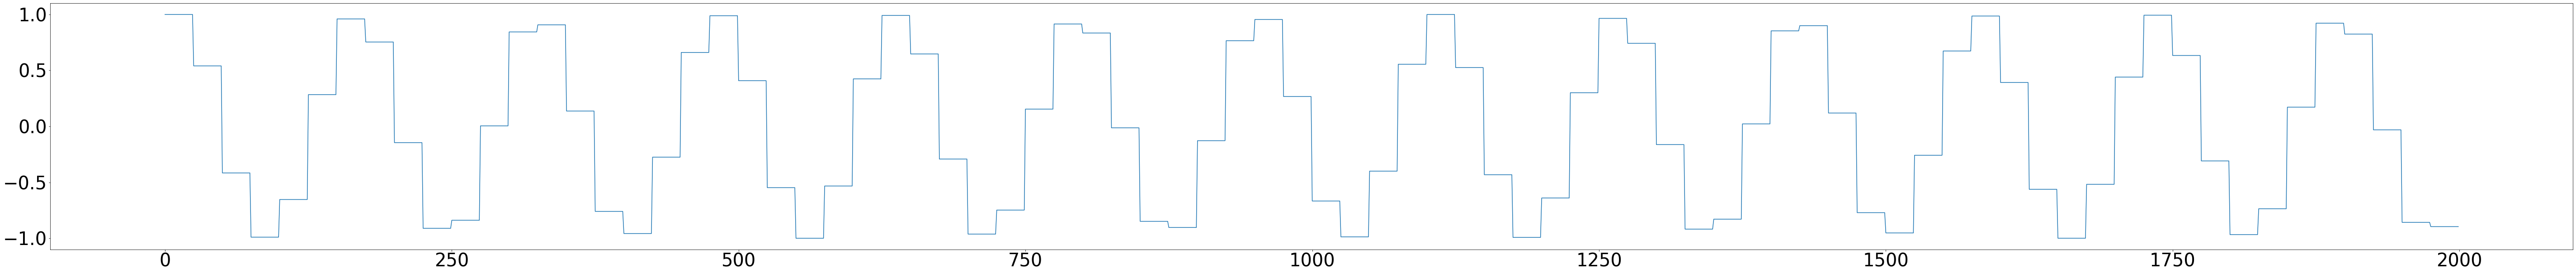

Showing: from 0 to 2000 - Shape of data: (99000,)


In [22]:
raw_1 = generate_raw_signal(max_degrees=360, steps_ratio=0.04)
data_1 = stack_data(raw_1, 10, to_radians=False)
cos_signal =np.cos(data_1)
print(f'total timesteps: {cos_signal.shape[0]}')
show_samples = 0, 500
showme(cos_signal, samples=show_samples)
show_samples = 0, 2000
showme(cos_signal, samples=show_samples)

max_degrees: 360 steps: 5142
Shape of data: (15426,)


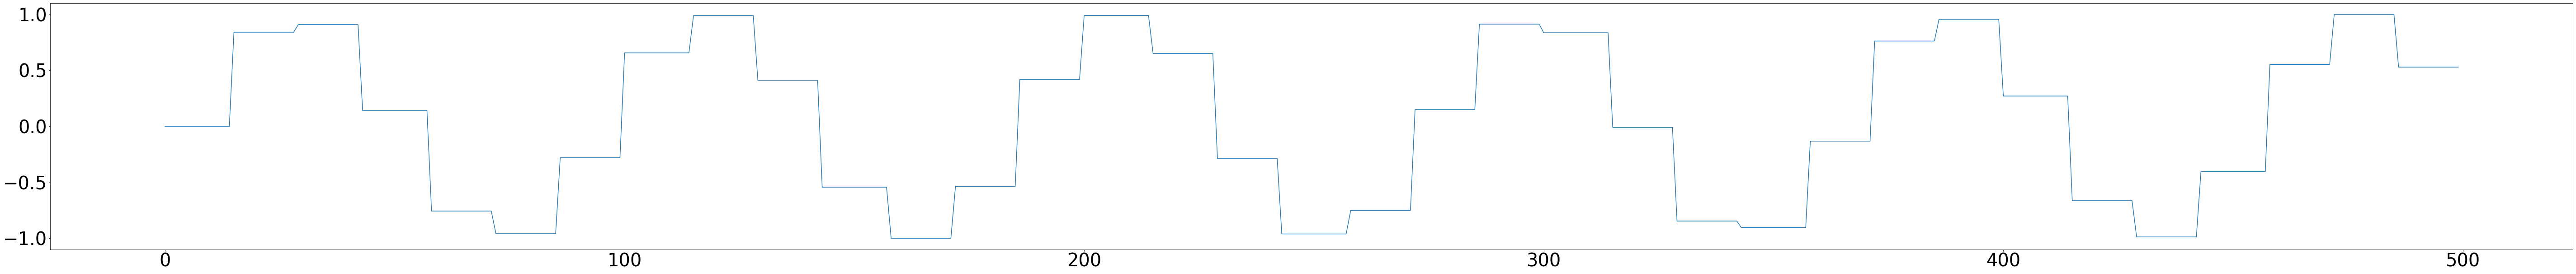

Showing: from 0 to 500 - Shape of data: (15426,)


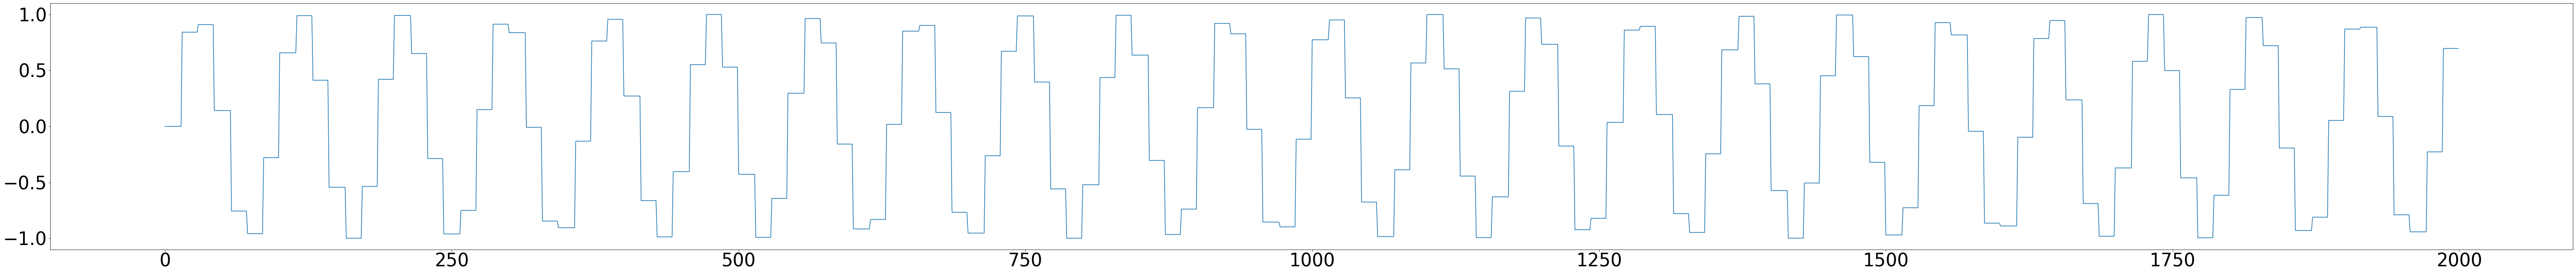

Showing: from 0 to 2000 - Shape of data: (15426,)


In [24]:
raw_2 = generate_raw_signal(max_degrees=360, steps_ratio=0.07)
data_2 = stack_data(raw_2, 2, to_radians=False)
sin_signal =np.sin(data_2)
show_samples = 0, 500
showme(sin_signal, samples=show_samples)
show_samples = 0, 2000
showme(sin_signal, samples=show_samples)

In [25]:
print(f'min: {np.min(cos_signal)} max: {np.max(cos_signal)} mean:{np.mean(cos_signal)}')



min: -0.999999999545659 max: 1.0 mean:0.004155965101804693


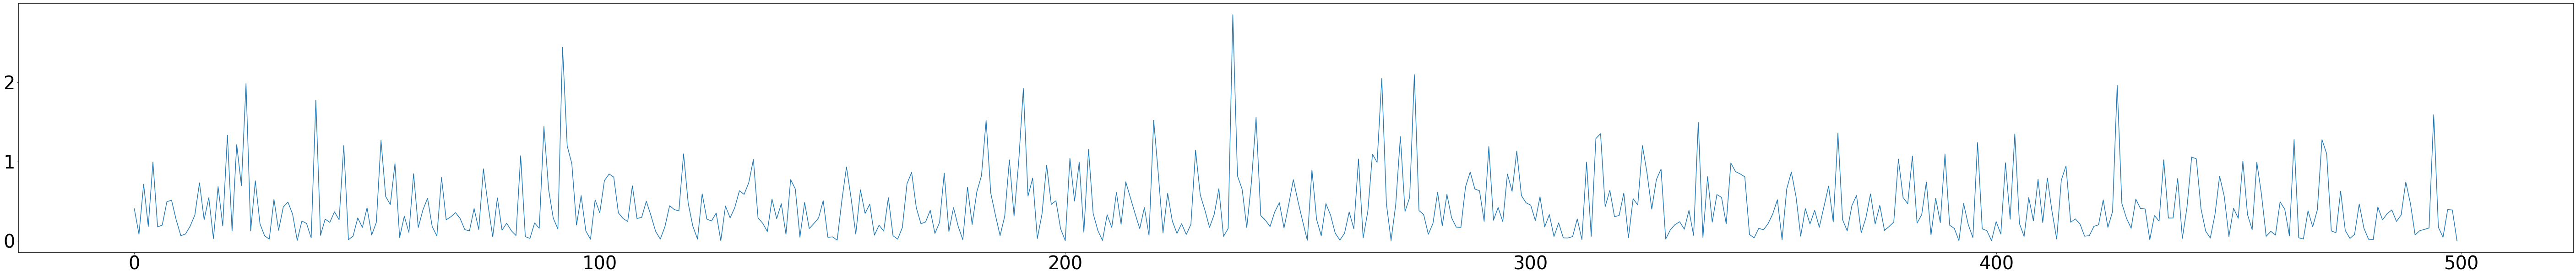

Showing: from 0 to 500 - Shape of data: (99000,)


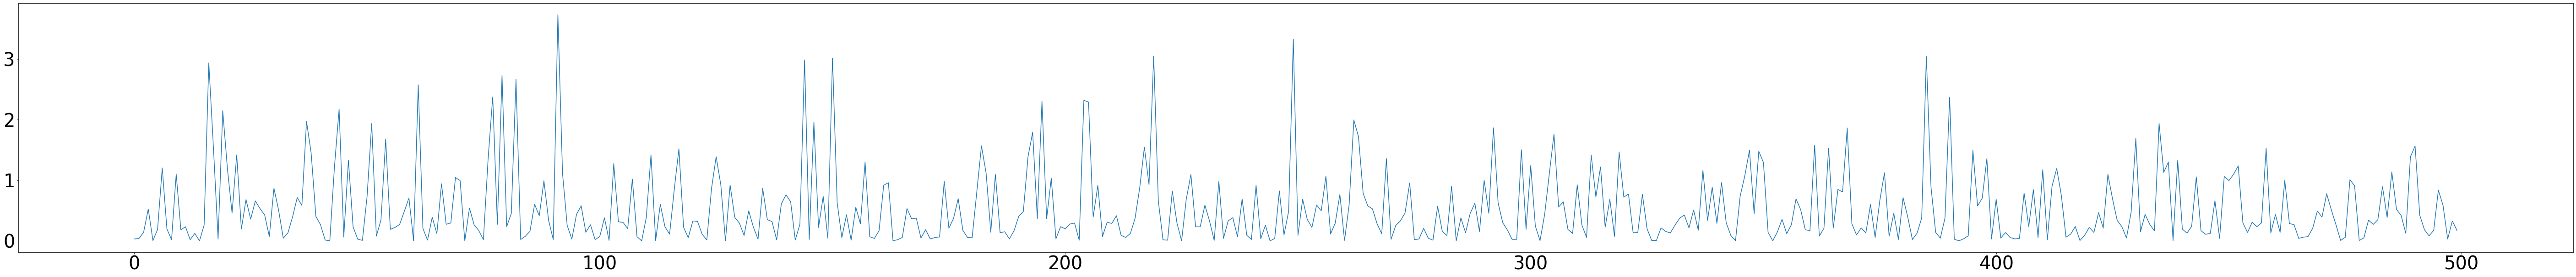

Showing: from 0 to 500 - Shape of data: (15426,)


In [59]:
random_signal_1 = skewed_noise(len(cos_signal), params=(1.1, .4))
showme(random_signal_1, 500)

random_signal_2 = skewed_noise(len(sin_signal), params=(.7, .7))
showme(random_signal_2, 500)

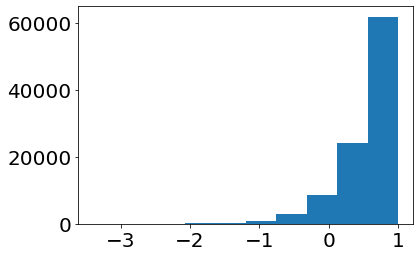

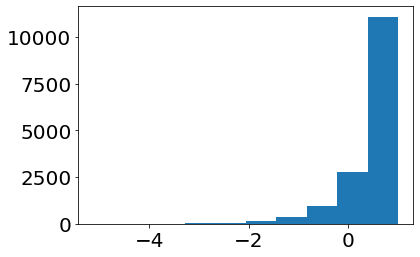

In [61]:
set_plt_font(20)
random_signal_1 = 1- random_signal_1
plt.hist(random_signal_1)
plt.show()

random_signal_2 = 1- random_signal_2
plt.hist(random_signal_2)
plt.show()

In [62]:
print('Noise 1')
print(f'mean: {np.mean(random_signal_1)}\nstd: {np.std(random_signal_1)}\nmax: {np.max(random_signal_1)}\nmin: {np.min(random_signal_1)}\nmedia: {np.median(random_signal_1)}')

print('Noise 2')
print(f'mean: {np.mean(random_signal_2)}\nstd: {np.std(random_signal_2)}\nmax: {np.max(random_signal_2)}\nmin: {np.min(random_signal_2)}\nmedia: {np.median(random_signal_2)}')

Noise 1
mean: 0.561421970064568
std: 0.41693020895494176
max: 0.9999952837272124
min: -3.387722147171761
media: 0.6845144087658016
Noise 2
mean: 0.5012135614104326
std: 0.5924745938024913
max: 0.9999998912462437
min: -5.118149882026371
media: 0.706488606133619


[0.41584171 1.0557533  1.25451251 1.82601595 1.82903417 2.40504692
 2.96460592 3.31784259 3.65823588 4.17262711]


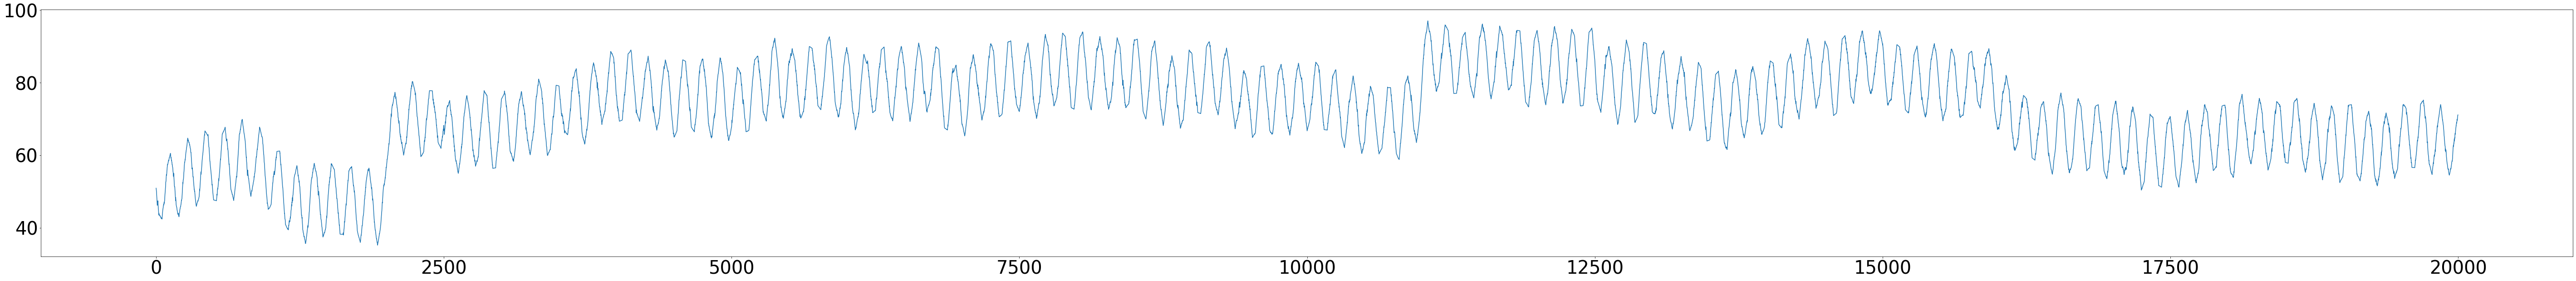

Showing: from 79000 to 99000 - Shape of data: (99000,)
0.0 - 71.14130563068893 - 71.14130563068893
[71.14130563 71.14130563 71.14130563 71.14130563 71.14130563 71.14130563
 71.14130563 71.14130563 71.14130563 71.14130563]


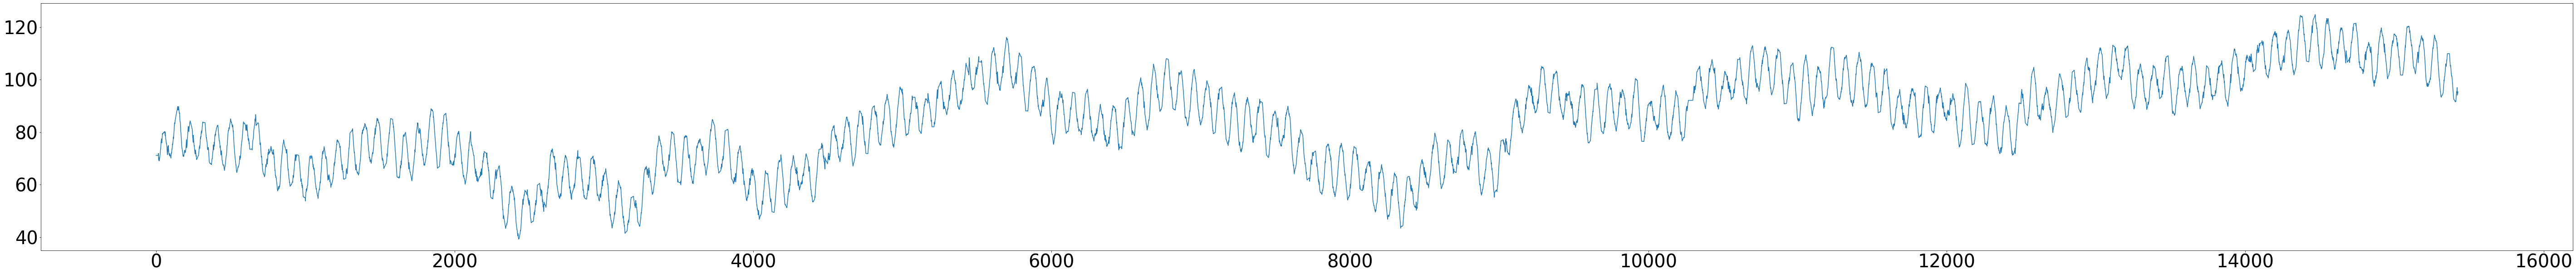

Showing: from 0 to 20000 - Shape of data: (15426,)


In [89]:
set_plt_font(40)

s_mixed = signal_fusion(cos_signal, random_signal_1, size_coef=.7)
showme(s_mixed, ( len(cos_signal)-20000, len(cos_signal)))#  show_samples)

s_production = signal_fusion(sin_signal, random_signal_2, size_coef=1.2, starting_point=s_mixed[-1])
showme(s_production, (0, 20000)) # show_samples)

In [91]:
len(s_production)

15426

training


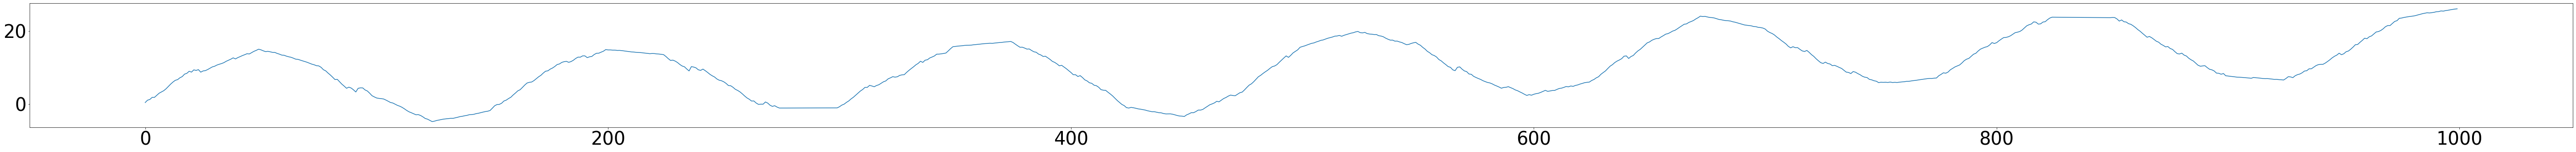

Showing: from 0 to 1000 - Shape of data: (99000,)


"production"


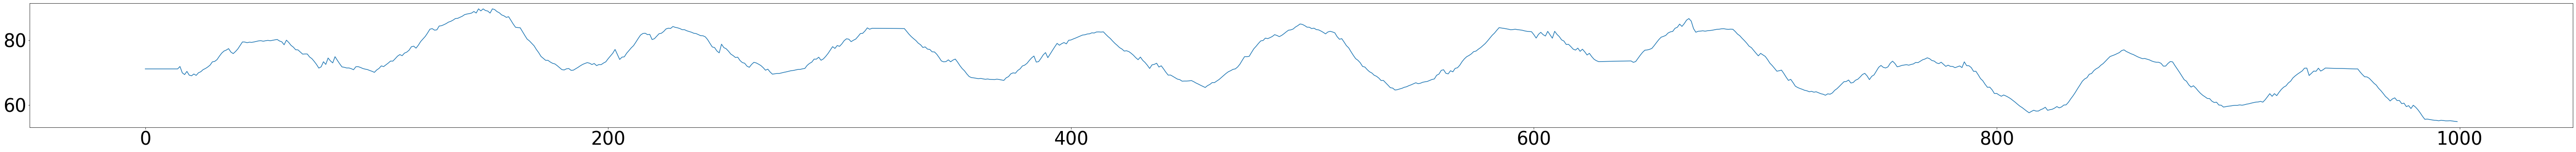

Showing: from 0 to 1000 - Shape of data: (15426,)



training


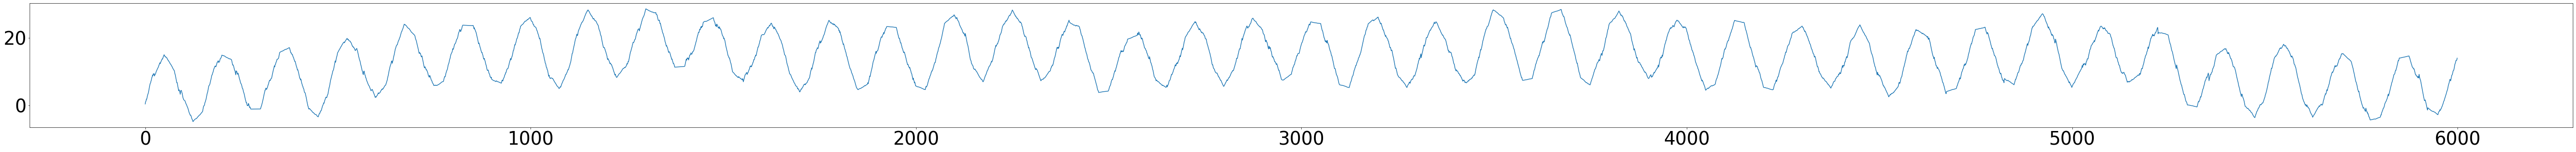

Showing: from 0 to 6000 - Shape of data: (99000,)


"production"


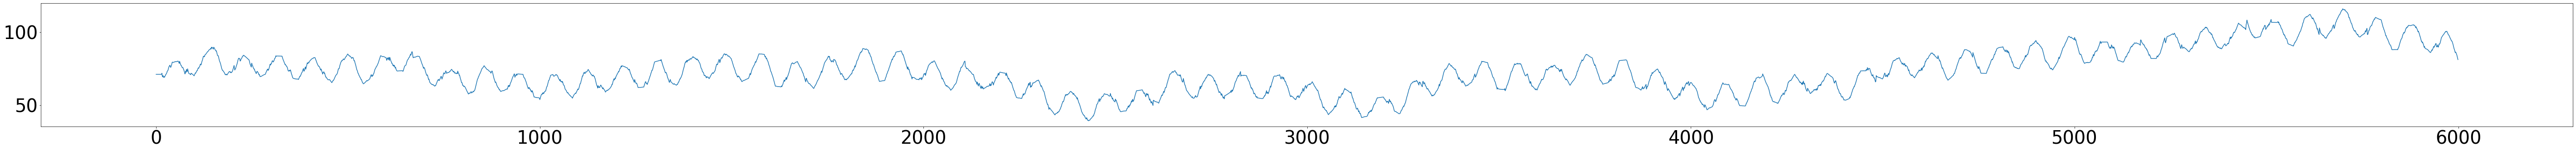

Showing: from 0 to 6000 - Shape of data: (15426,)



training


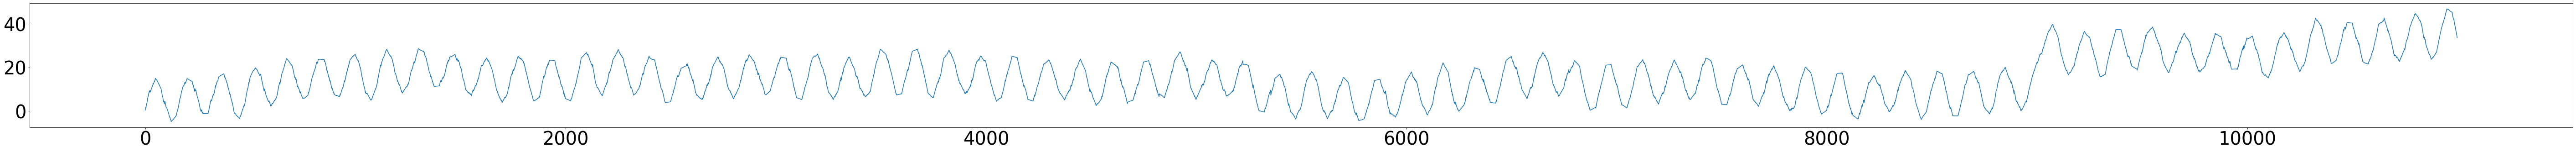

Showing: from 0 to 11000 - Shape of data: (99000,)


"production"


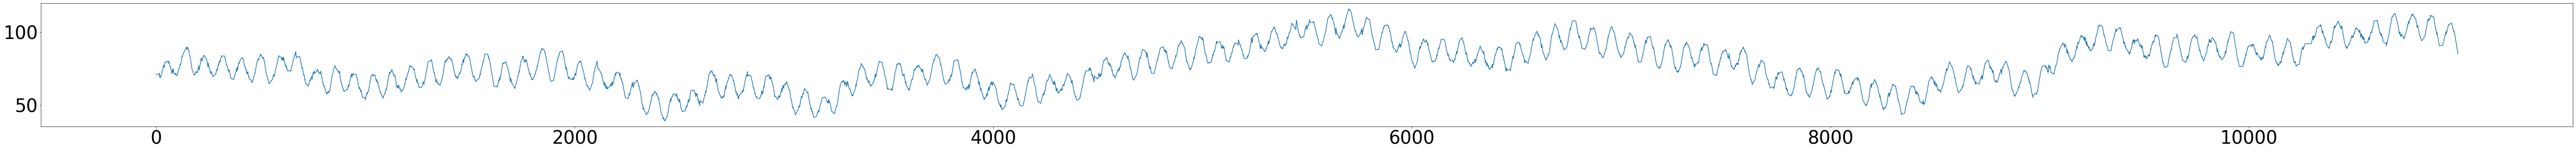

Showing: from 0 to 11000 - Shape of data: (15426,)



training


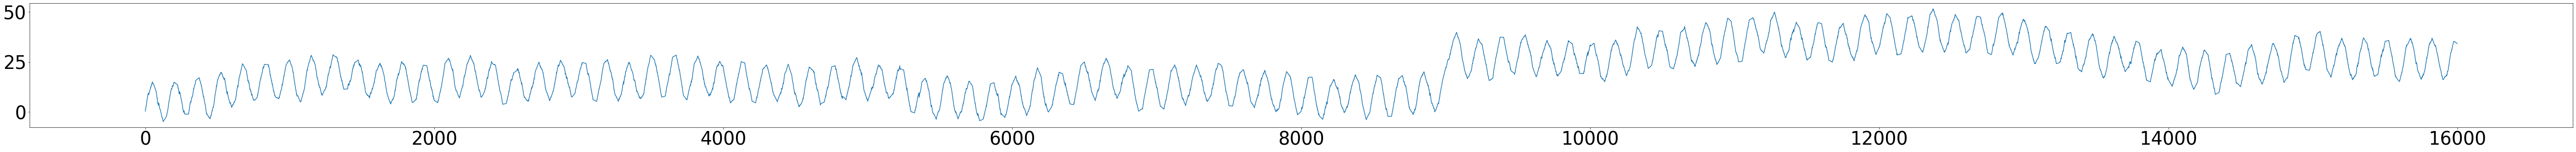

Showing: from 0 to 16000 - Shape of data: (99000,)


"production"


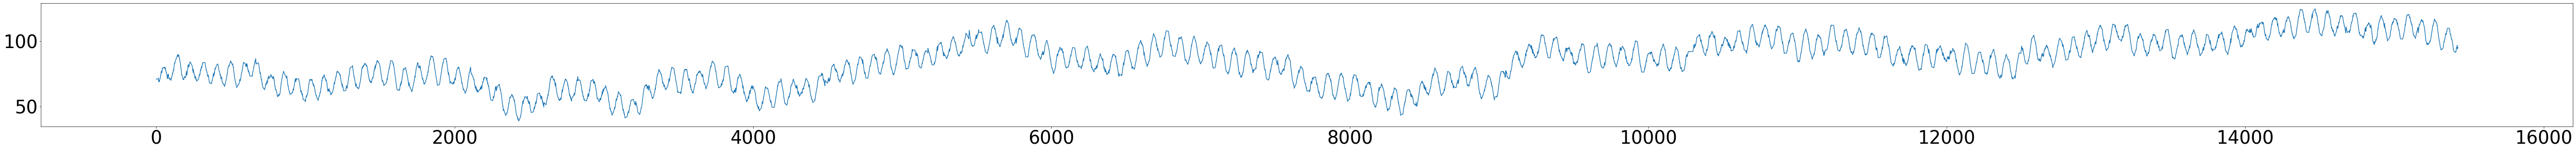

Showing: from 0 to 16000 - Shape of data: (15426,)





In [92]:
for steps_to_show in range(1000,20000,5000):
  print('training')
  showme(s_mixed, steps_to_show, h=5)
  print('\n')
  print('"production"')
  showme(s_production, steps_to_show, h=5)
  print('\n'*2)

  

### Model training

#### Prepare sequences

In [93]:
sequenced_signal = rolling_window(s_mixed, 100)
print(f'Shape of sequenced signal: {sequenced_signal.shape}\n')

X, y = seq2inputs(sequenced_signal)

X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

Shape of sequenced signal: (98901, 100)

Shape of feature: (98900, 100) - Shape of target: (98900,)
n_train: 63296 - n_train_pre: 79120
X_train shape: (63296, 100)
y_train shape: (63296,)
X_val shape: (15824, 100)
y_val shape: (15824,)
X_test shape: (19780, 100)
y_test shape: (19780,)


#### Explorative dev phase - training

In [94]:
model = Sequential([
  Dense(64, activation='relu'),
  Dense(16, activation='relu'),
  Dense(1)
])

In [95]:
model.compile(
  Adam(learning_rate=0.0001),
  loss= MeanSquaredError(),  #MeanAbsoluteError(),
  metrics=['mse']  
)

In [96]:
model.fit(
  X_train,
  y_train,
  epochs=3,
  validation_data=(X_val, y_val),
)

Epoch 1/3
1978/1978 [==============================] - 3s 1ms/step - loss: 124.2622 - mse: 124.2622 - val_loss: 0.6520 - val_mse: 0.6520
Epoch 2/3
1978/1978 [==============================] - 3s 1ms/step - loss: 0.6510 - mse: 0.6510 - val_loss: 0.4731 - val_mse: 0.4731
Epoch 3/3
1978/1978 [==============================] - 3s 1ms/step - loss: 0.4639 - mse: 0.4639 - val_loss: 0.2962 - val_mse: 0.2962


In [97]:
model.save('models/signal_one')

INFO:tensorflow:Assets written to: models/signal_one/assets


In [98]:
print(model.evaluate(X_test, y_test, verbose=2))
predictions = model.predict(X_test)


619/619 - 0s - loss: 0.3407 - mse: 0.3407 - 464ms/epoch - 749us/step
[0.3407307267189026, 0.3407307267189026]


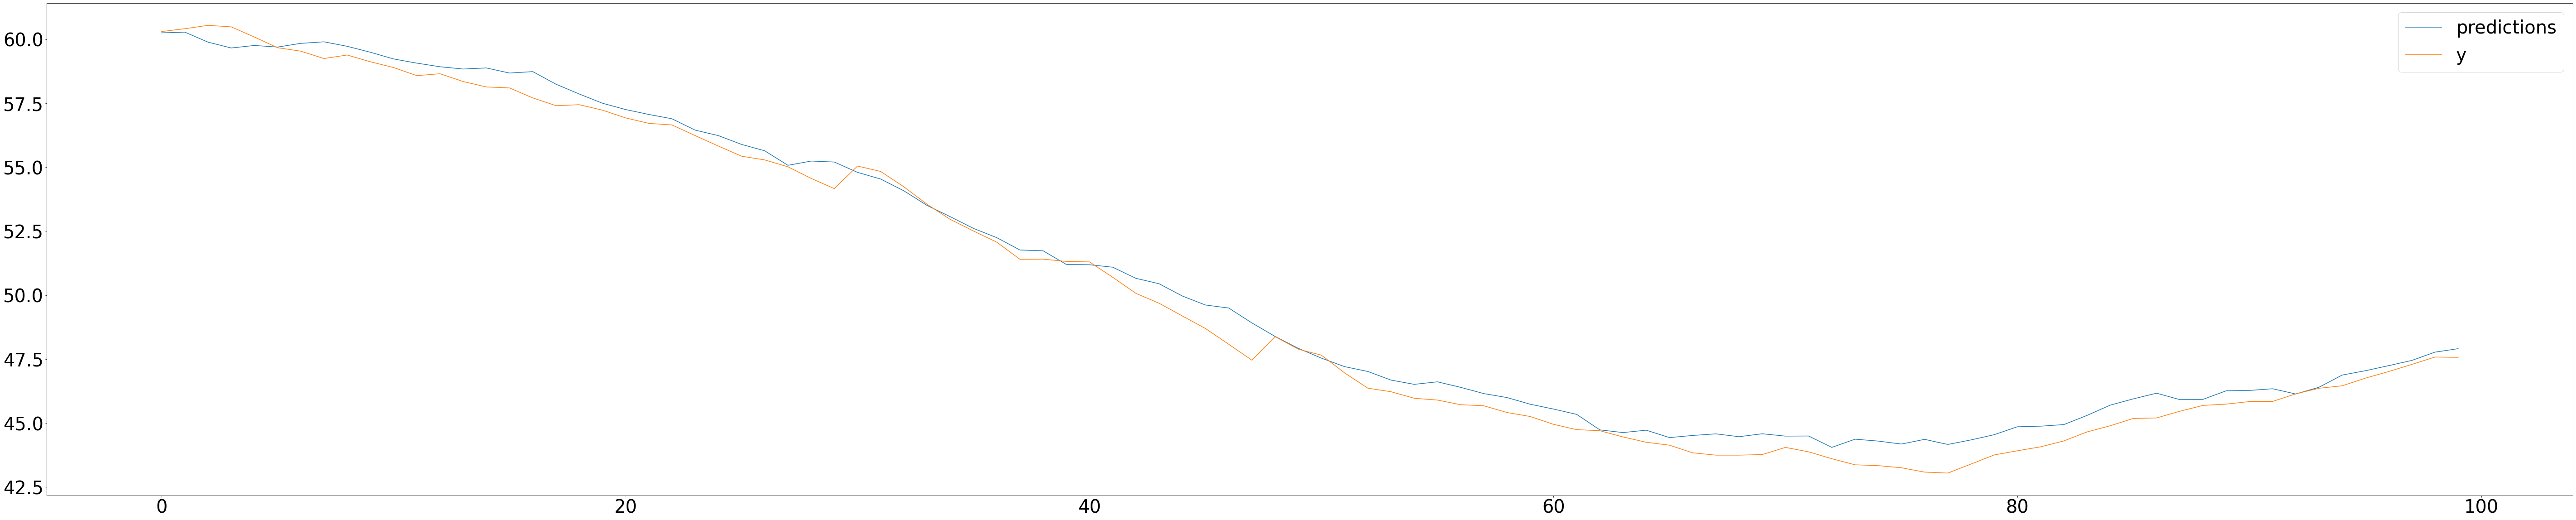

In [99]:
plt.figure(figsize=(100,20))

ix = 0
steps = 100
plt.plot(predictions[ix:ix+steps], label = "predictions")
plt.plot(y_test[ix:ix+steps], label = "y")
plt.legend()
plt.show()

from timestep: 1000 to timestep: 11000


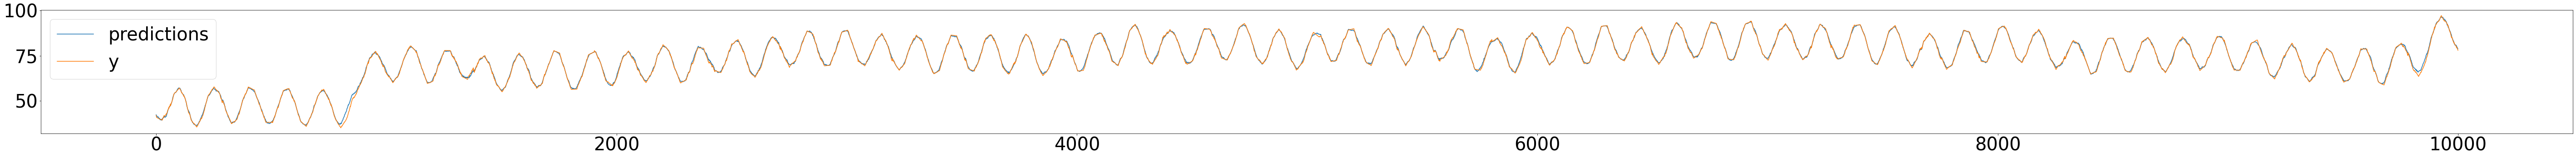

from timestep: 5000 to timestep: 15000


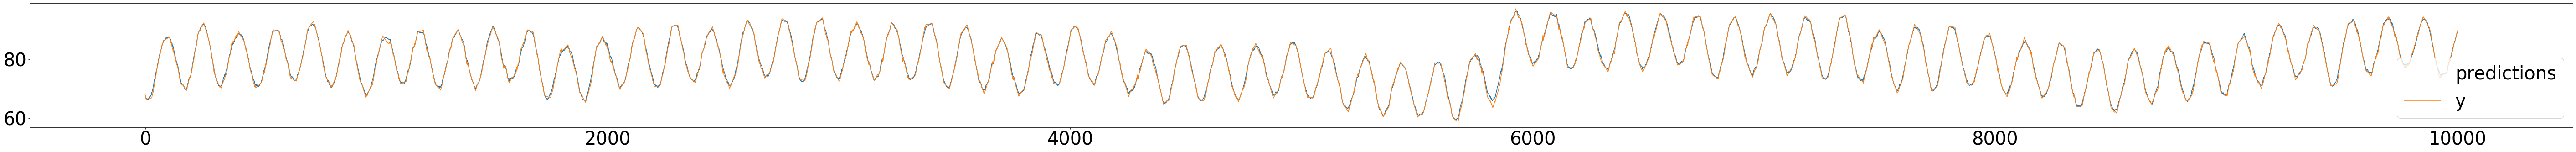

from timestep: 9000 to timestep: 19000


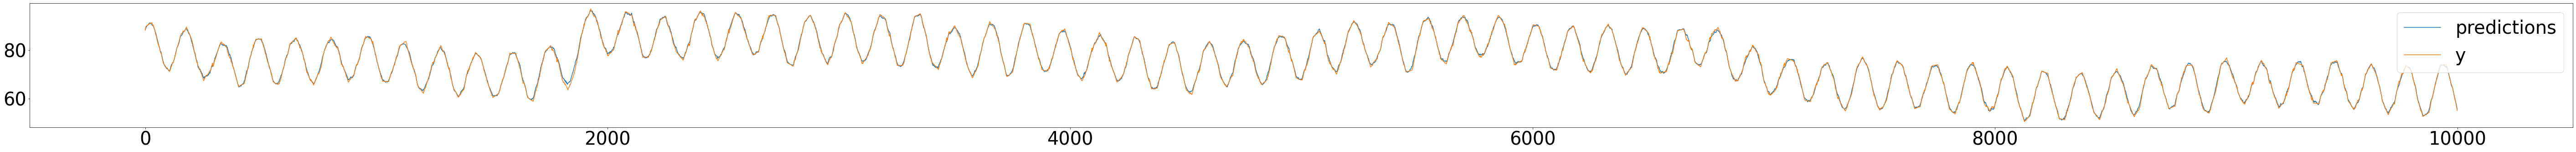

from timestep: 13000 to timestep: 19780


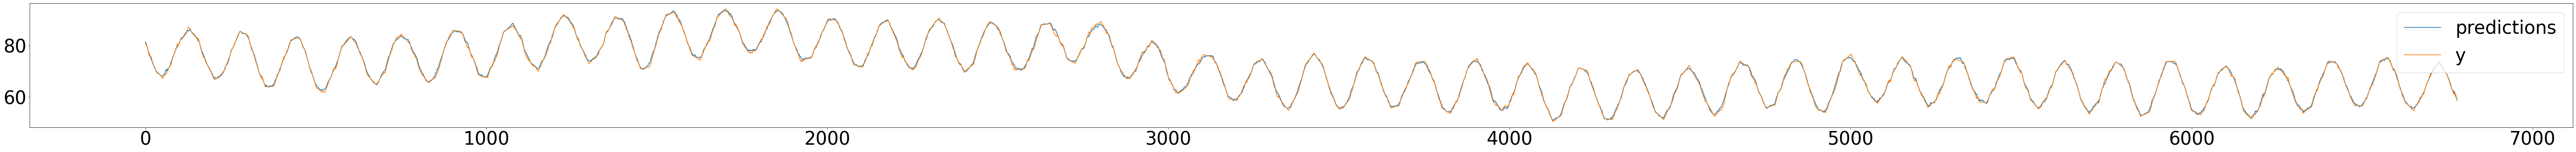

from timestep: 17000 to timestep: 19780


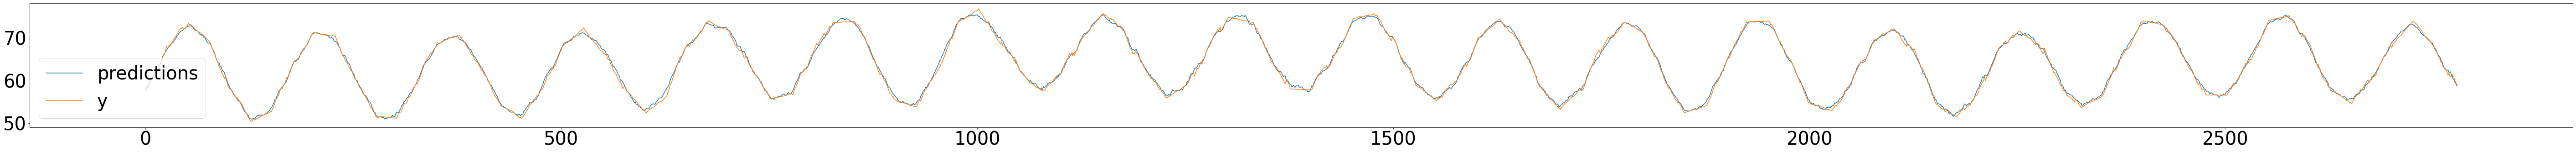

In [100]:
for steps_to_show in range(1000,20000,4000):
  plt.figure(figsize=(100,5))
  ix = steps_to_show
  steps = 10000
  limit = ix+steps if len(y_test)>ix+steps else len(y_test)
  print(f'from timestep: {ix} to timestep: {limit}')
  plt.plot(predictions[ix:ix+steps], label = "predictions")
  plt.plot(y_test[ix:ix+steps], label = "y")
  plt.legend()
  plt.show()
  

### New data arrives

/var/folders/sm/_m8tc2l97fqbht869xgfjc4h0000gn/T/ipykernel_31826/2360070466.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coef = np.linspace(0, 1, n_transition_steps).astype(np.float)


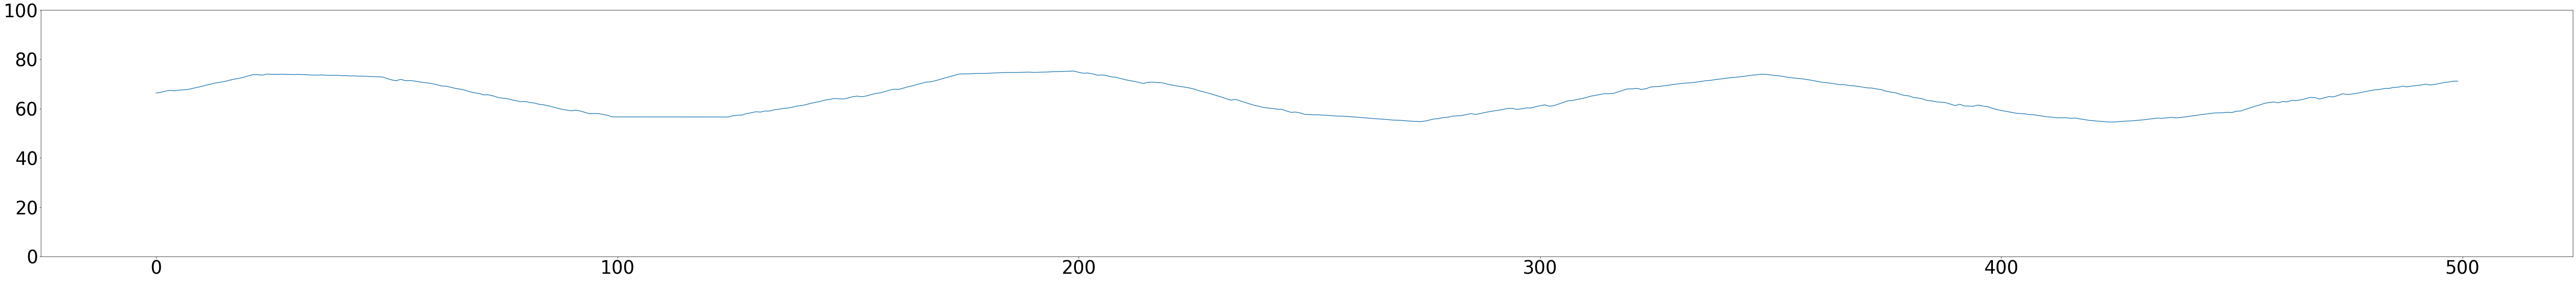

Showing: from 0 to 2000 - Shape of data: (500,)


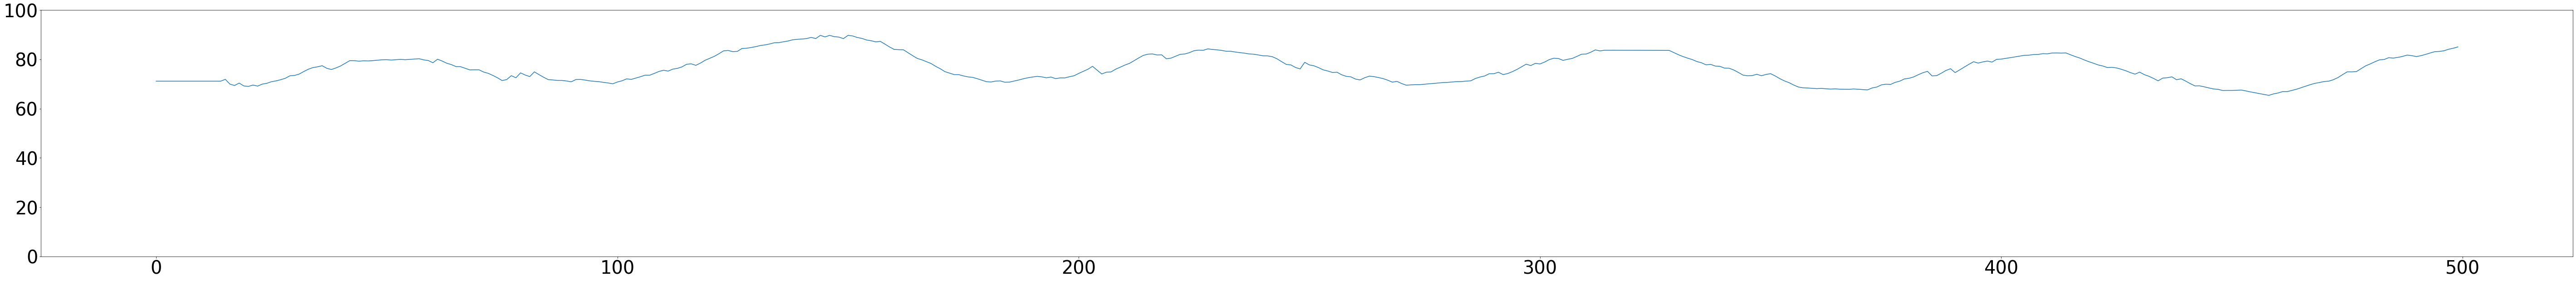

Showing: from 0 to 2000 - Shape of data: (500,)


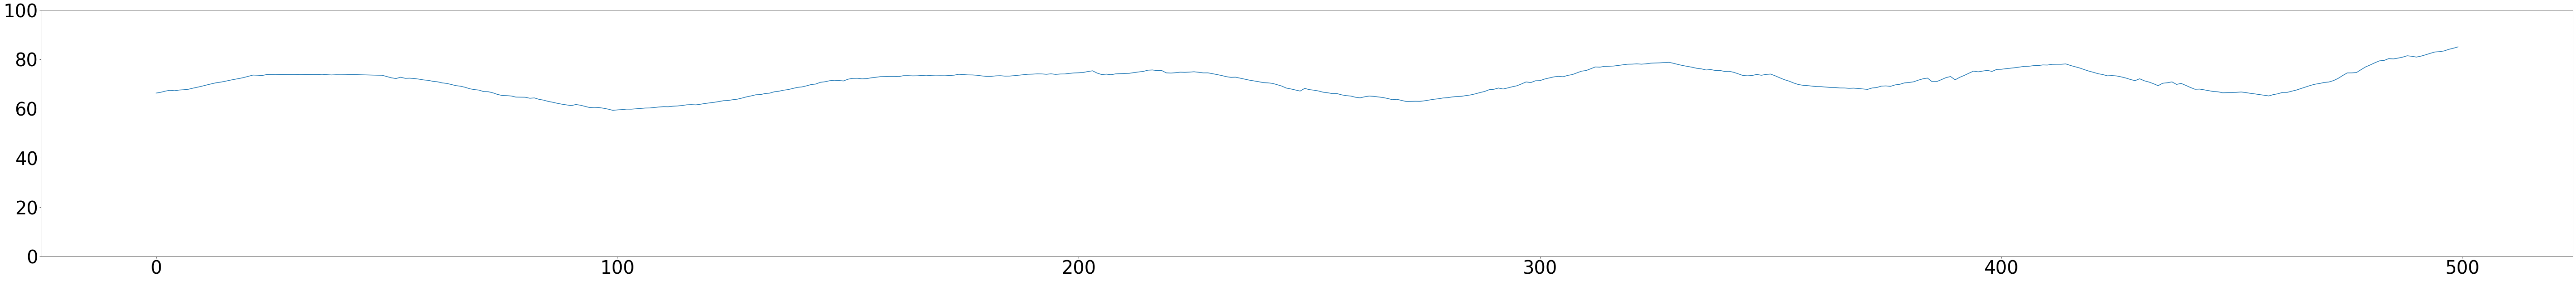

Showing: from 0 to 2000 - Shape of data: (500,)


In [110]:
n_transition_steps = 500
coef = np.linspace(0, 1, n_transition_steps).astype(np.float)
transition_signal = (s_mixed[-n_transition_steps:]*(1-coef) + s_production[:n_transition_steps]*coef)
showme(s_mixed[-n_transition_steps:], show_samples, y_axis_lim=(0,100))
showme(s_production[:n_transition_steps], show_samples, y_axis_lim=(0,100))
showme(transition_signal, show_samples, y_axis_lim=(0,100))


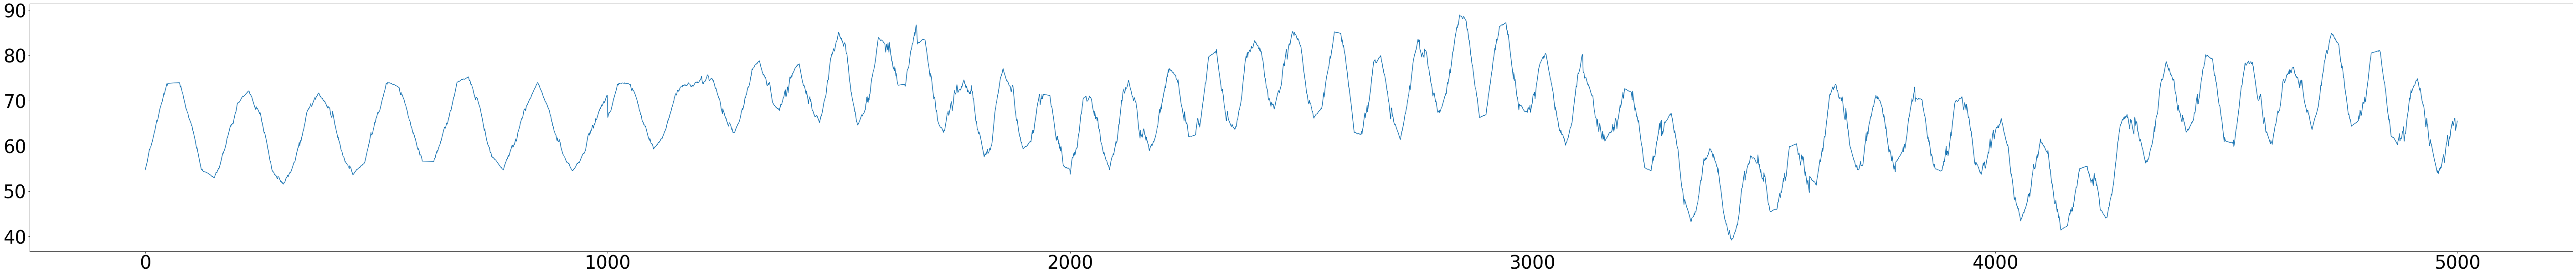

Showing: from 4000 to 9000 - Shape of data: (20426,)


In [132]:
concat_signal = np.concatenate((s_mixed[-5000:], transition_signal, s_production[n_transition_steps:]))
showme(concat_signal, (4000,9000))

In [133]:
sequenced_signal_prod = rolling_window(concat_signal, 100)
print(f'Shape of sequenced signal: {sequenced_signal_prod.shape}\n')
X, y = seq2inputs(sequenced_signal_prod)
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(X, y)
print(f'X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}\nX_val shape: {X_val.shape}\ny_val shape: {y_val.shape}\nX_test shape: {X_test.shape}\ny_test shape: {y_test.shape}')

Shape of sequenced signal: (20327, 100)

Shape of feature: (20326, 100) - Shape of target: (20326,)
n_train: 13008 - n_train_pre: 16260
X_train shape: (13008, 100)
y_train shape: (13008,)
X_val shape: (3252, 100)
y_val shape: (3252,)
X_test shape: (4066, 100)
y_test shape: (4066,)


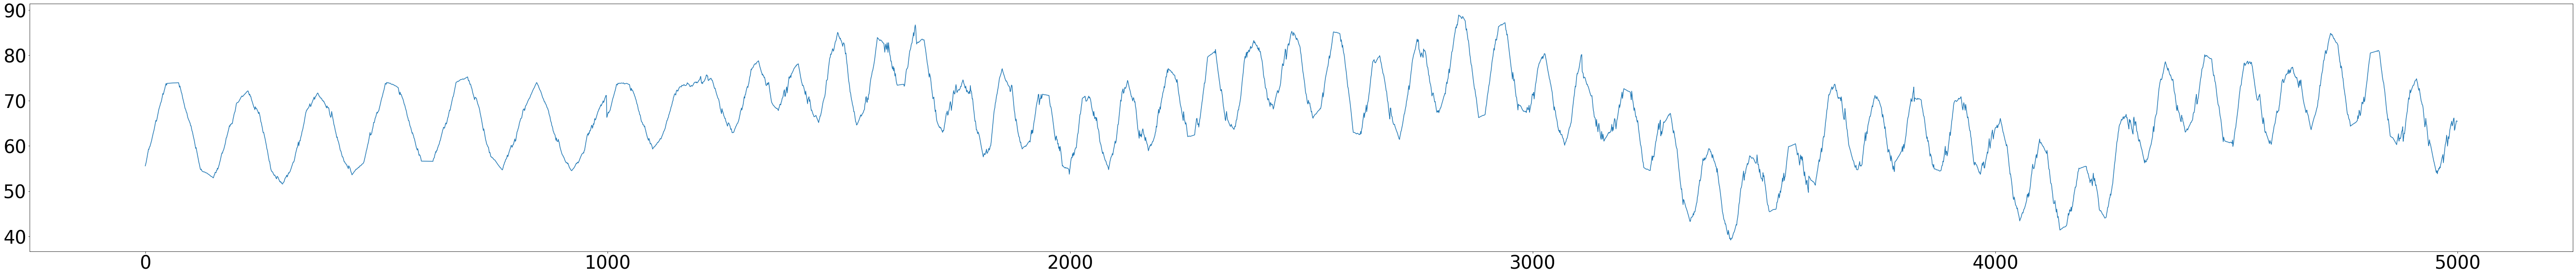

Showing: from 4000 to 9000 - Shape of data: (13008,)


In [136]:
showme(y_train, (4000,9000))

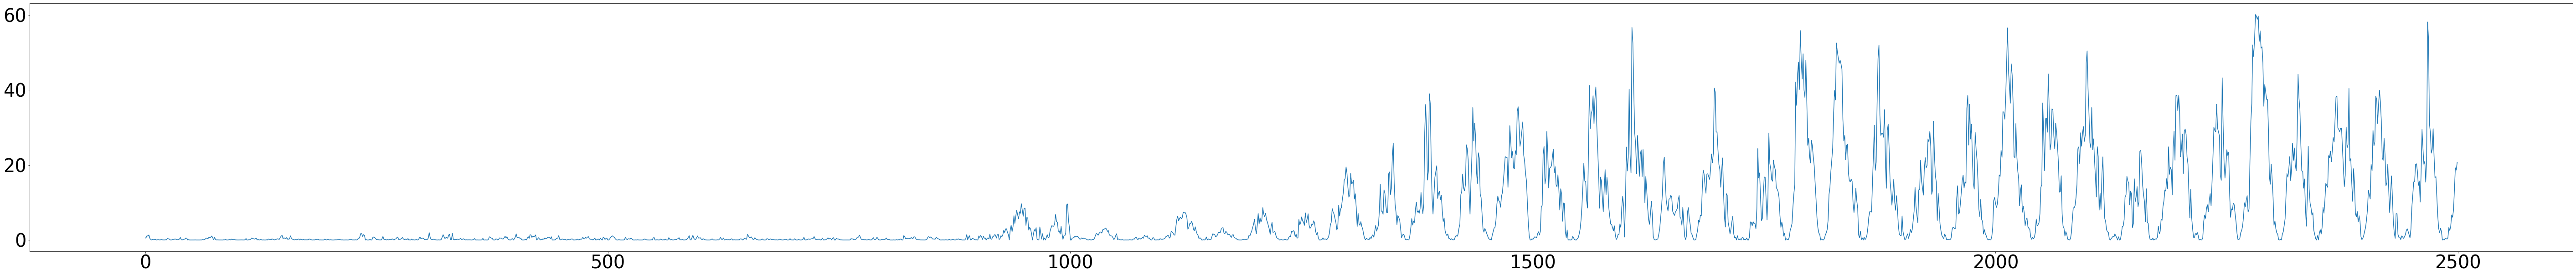

Showing: from 0 to 2500 - Shape of data: (5000,)


In [138]:
mses = []
steps_to_predict=1
# for x in range(4000, 9000):
  print(f'from {x} to {x+steps_to_predict}', end='\r')
  mses.append(model.evaluate(X_train[x:x+steps_to_predict], y_train[x:x+steps_to_predict], verbose=0)[0])
# print(mses)
  # predictions = model.predict(X_train)
# showme(np.array(mses), (0,2500))

In [147]:
print(len(X_train))
model = load_model('models/signal_one')
model_two = load_model('models/signal_one')

13008


In [162]:
def show_behavior(predictions_1: np.array, predictions_2: np.array, ground_truth:np.array):
  plt.figure(figsize=(50,5))
  plt.plot(predictions_1, label = "Prediction One")
  plt.plot(predictions_2, label = "Prediction Retrained")
  plt.plot(ground_truth, label = "Ground Truth")
  plt.legend()
  plt.show()

In [148]:
model_two.compile(
  Adam(learning_rate=0.005),
  loss= MeanSquaredError(),  
  metrics=['mse']  
)


Iteration: 0 -- training timesteps: from: 0 to 4000 predicting: from 4000 to 4100
4/4 [==============================] - 0s 16ms/step - loss: 0.1947 - mse: 0.1947
MSE iterations - New: 0.02 Old: 0.1947


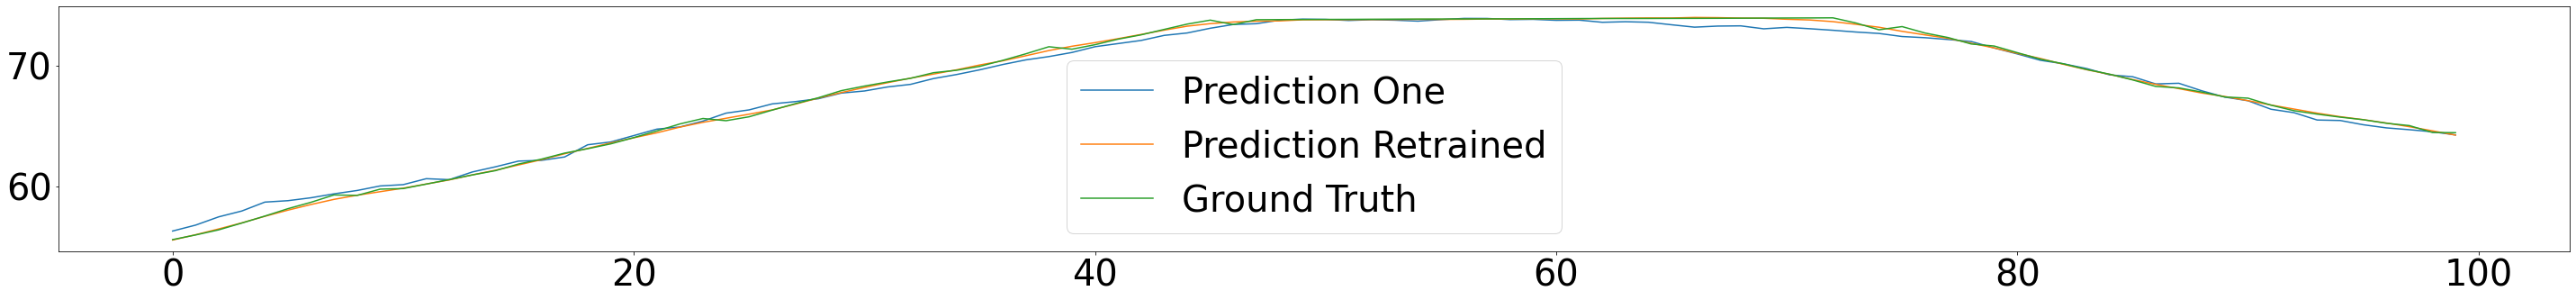

Iteration: 1 -- training timesteps: from: 500 to 4500 predicting: from 4500 to 4600
4/4 [==============================] - 0s 1ms/step - loss: 0.2204 - mse: 0.2204
MSE iterations - New: 0.02 Old: 0.2204


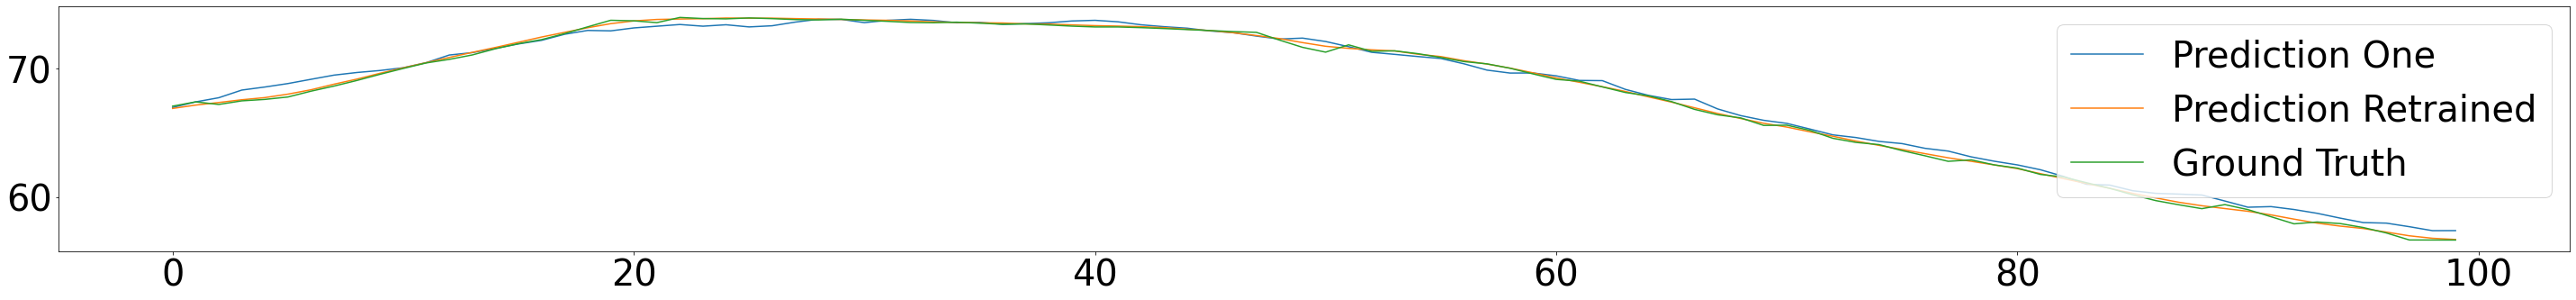

Iteration: 2 -- training timesteps: from: 1000 to 5000 predicting: from 5000 to 5100
4/4 [==============================] - 0s 1ms/step - loss: 0.6571 - mse: 0.6571
MSE iterations - New: 0.08 Old: 0.6571


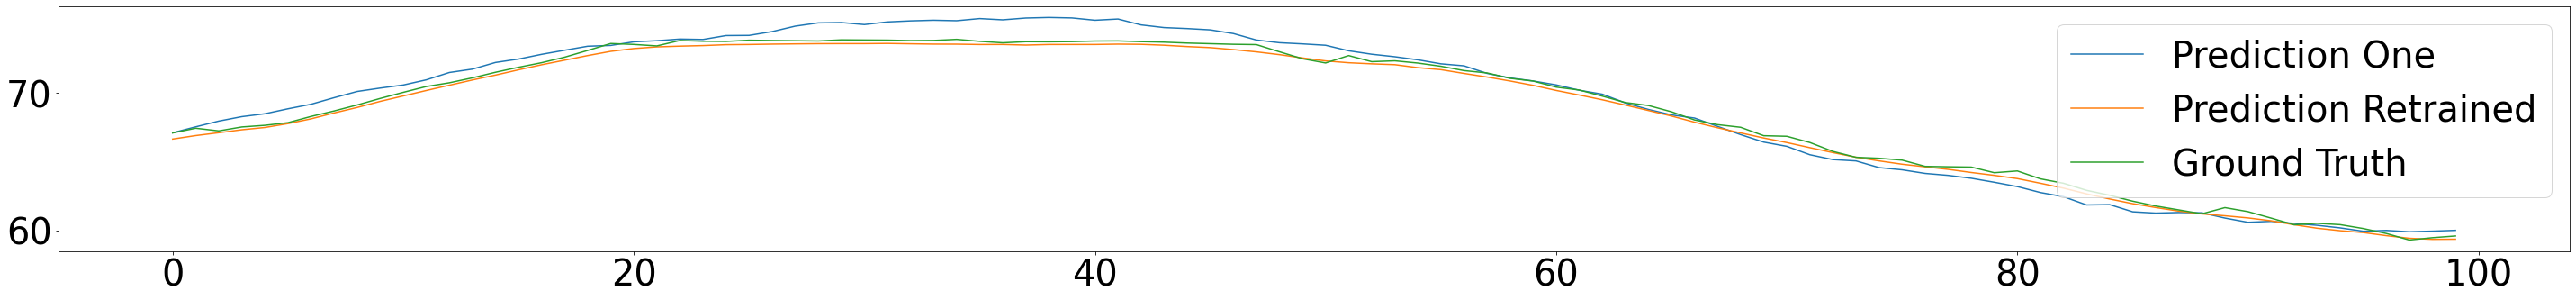

Iteration: 3 -- training timesteps: from: 1500 to 5500 predicting: from 5500 to 5600
4/4 [==============================] - 0s 1ms/step - loss: 11.4061 - mse: 11.4061
MSE iterations - New: 0.14 Old: 11.4061


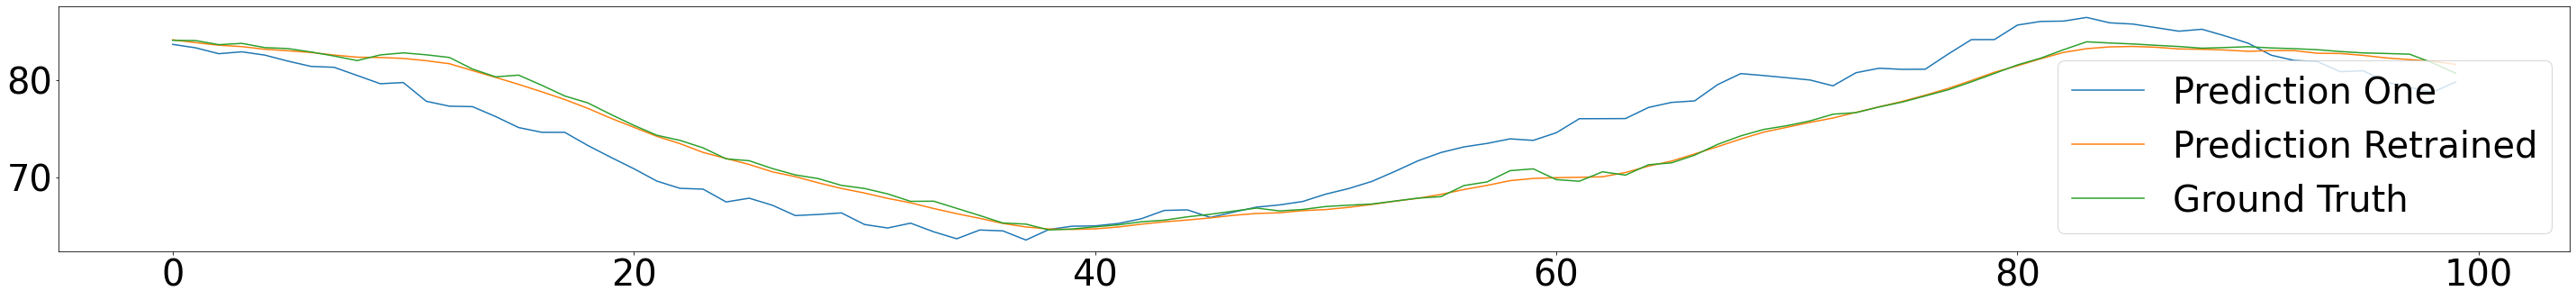

Iteration: 4 -- training timesteps: from: 2000 to 6000 predicting: from 6000 to 6100
4/4 [==============================] - 0s 1ms/step - loss: 18.7840 - mse: 18.7840
MSE iterations - New: 0.08 Old: 18.784


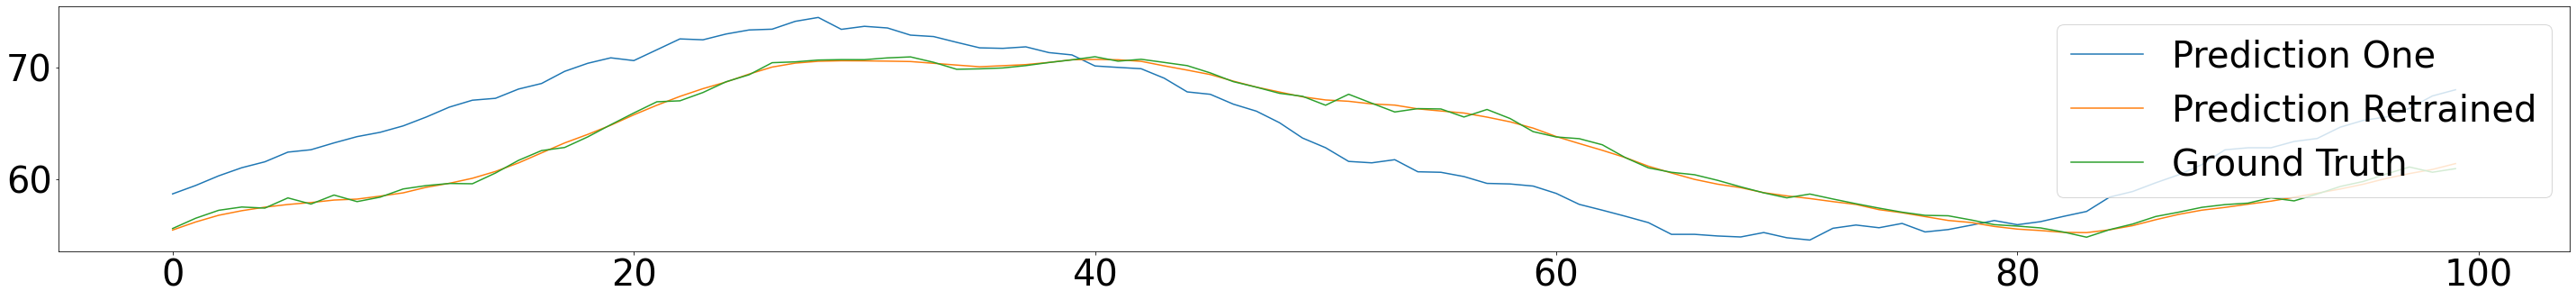

In [166]:
n_input_sequences = 4000
n_prediction_sequences = 100
for ix, tix in enumerate(range(0, 2500, 500)):
  trax = X_train[tix:tix+n_input_sequences] 
  tray = y_train[tix:tix+n_input_sequences]
  tstx = X_train[tix+n_input_sequences:tix+n_input_sequences+n_prediction_sequences]
  tsty = y_train[tix+n_input_sequences:tix+n_input_sequences+n_prediction_sequences] 
  print(f'Iteration: {ix} -- training timesteps: from: {tix} to {tix+n_input_sequences} predicting: from {tix+n_input_sequences} to {tix+n_input_sequences+n_prediction_sequences}')

  model_two.fit(trax,tray, epochs=5 , verbose=0)
  print(f'MSE iterations - New: {round(model_two.evaluate(tstx, tsty, verbose=0)[0],2)} Old: {round(model.evaluate(tstx, tsty)[0],4)}')

  predictions_1 = model.predict(tstx)
  predictions_2 = model_two.predict(tstx)

  show_behavior(predictions_1, predictions_2, tsty)
  


In [ ]:
for steps_to_show in range(1000,20000,4000):
  plt.figure(figsize=(100,5))
  ix = steps_to_show
  steps = 10000
  limit = ix+steps if len(y_test)>ix+steps else len(y_test)
  print(f'from timestep: {ix} to timestep: {limit}')
  plt.plot(predictions[ix:ix+steps], label = "predictions")
  plt.plot(y_test[ix:ix+steps], label = "y")
  plt.legend()
  plt.show()